[*********************100%%**********************]  1 of 1 completed

Precio predicho para 2024-06-30 : 18.429625329426912


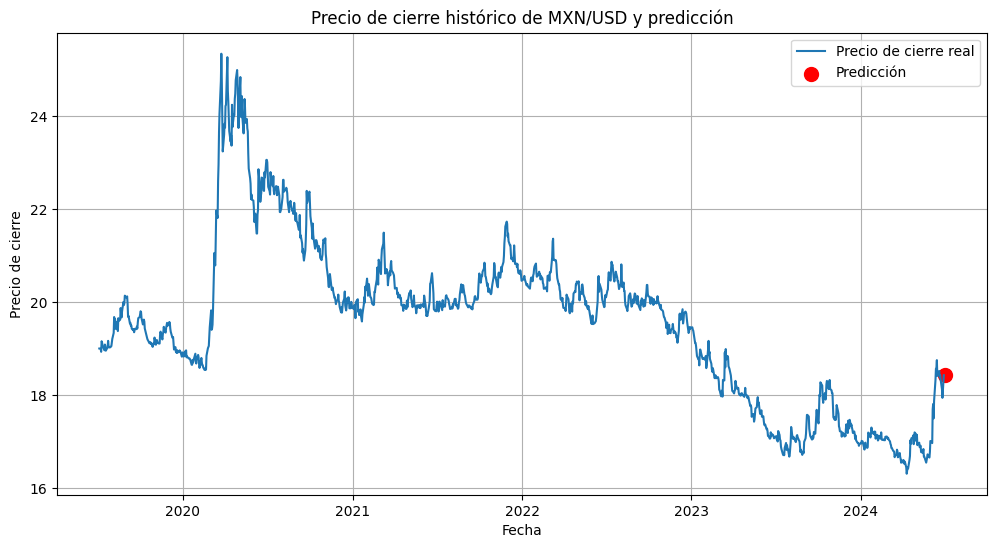

In [24]:
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Download historical price data
symbol = "MXN=X"
start_date = pd.Timestamp.today() - pd.Timedelta(weeks=260)
end_date = pd.Timestamp.today()
df = yf.download(symbol, start=start_date, end=end_date)

# Preprocess data
X = df[['Open','High', 'Low']]
y = df['Close']

# Train model
model = LinearRegression()
model.fit(X, y)

# Make predictions
last_row = df.tail(1)
X_pred = last_row[['Open', 'High', 'Low']]
date_pred = last_row.index[0] + pd.Timedelta(days=2)  # predict the next day's price
y_pred = model.predict(X_pred)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Precio de cierre real')
plt.scatter(date_pred, y_pred, color='red', marker='o', s=100, label='Predicción')

# Customize the plot
plt.title('Precio de cierre histórico de MXN/USD y predicción')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.legend()

# Show the predicted price
print('Precio predicho para', date_pred.strftime('%Y-%m-%d'), ':', y_pred[0])

# Display the plot
plt.grid(True)
plt.show()

Epoch 1/25
63/63 [==============================] - 10s 85ms/step - loss: 0.0213 - val_loss: 0.0028
Epoch 2/25
63/63 [==============================] - 3s 53ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 3/25
63/63 [==============================] - 3s 53ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 4/25
63/63 [==============================] - 4s 56ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 5/25
63/63 [==============================] - 3s 54ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 6/25
63/63 [==============================] - 3s 54ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 7/25
63/63 [==============================] - 3s 53ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 8/25
63/63 [==============================] - 3s 48ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 9/25
63/63 [==============================] - 3s 53ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 10/25
63/63 [==============================] - 3s 51ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 11

c:\ProgramData\anaconda3\envs\finance\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


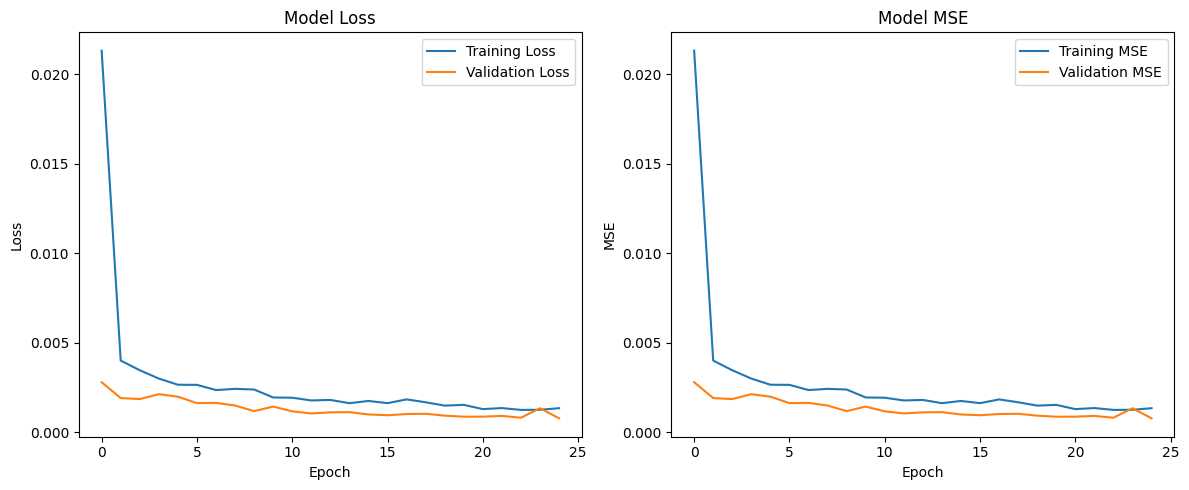

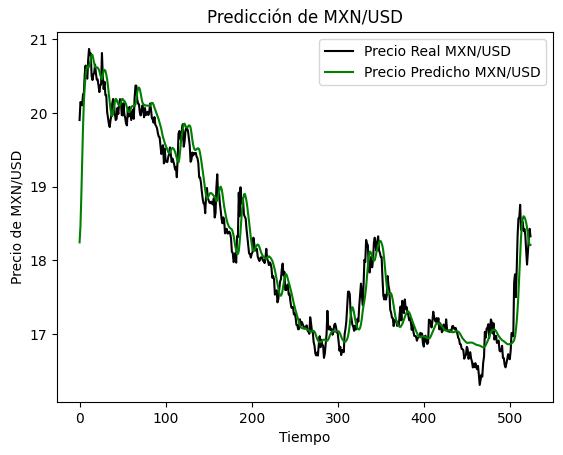

In [26]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model

with tf.device('/GPU:0'):
# Obtener datos de intercambio MXN/USD
    mxn_usd = yf.Ticker("MXN=X")
    data = mxn_usd.history(period="5y")

    # Preprocesamiento de datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

    # Preparar datos para LSTM
    prediction_days = 60

    x_train = []
    y_train = []

    for x in range(prediction_days, len(scaled_data)):
        x_train.append(scaled_data[x-prediction_days:x, 0])
        y_train.append(scaled_data[x, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Construir el modelo LSTM
    """
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))  # Predicción del próximo cierre
    """
    model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.1),
    LSTM(50, return_sequences=True),
    #BatchNormalization(),
    Dropout(0.1),
    LSTM(50),
    Dense(50, activation='relu'),
    Dense(1)
    ])
   
    model.compile(optimizer='adam', loss='mean_squared_error')
    """Agregados"""
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Entrenamiento con validación
    history = model.fit(
    x_train, y_train,
    epochs=25,
    batch_size=16,
    validation_split=0.2,  # Usar 20% de los datos para validación
    callbacks=[early_stopping]
    )
    #model.fit(x_train, y_train, epochs=250, batch_size=16)#150, 32

    plot_model(model, to_file='modelo_lstm.png', show_shapes=True, show_layer_names=True)
    # Preparar datos de prueba
    test_data = mxn_usd.history(period="2y")
    total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

    model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
    model_inputs = model_inputs.reshape(-1, 1)
    model_inputs = scaler.transform(model_inputs)

    x_test = []

    for x in range(prediction_days, len(model_inputs)):
        x_test.append(model_inputs[x-prediction_days:x, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Hacer predicciones
    predicted_prices = model.predict(x_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)
    print(predicted_prices)
    #Guardar modelo
    model.save('USD/MXN_model.h5')
    # Visualizar los resultados
    import matplotlib.pyplot as plt

    # Visualizar el historial de entrenamiento
    plt.figure(figsize=(12, 5))

    # Gráfica de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Gráfica de MSE (es lo mismo que la pérdida en este caso)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training MSE')
    plt.plot(history.history['val_loss'], label='Validation MSE')
    plt.title('Model MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    plt.tight_layout()
    plt.show()

    plt.plot(test_data['Close'].values, color='black', label='Precio Real MXN/USD')
    plt.plot(predicted_prices, color='green', label='Precio Predicho MXN/USD')
    plt.title('Predicción de MXN/USD')
    plt.xlabel('Tiempo')
    plt.ylabel('Precio de MXN/USD')
    plt.legend()
    plt.show()


1/1 [==============================] - 0s 19ms/step
Predicción para 2024-06-30: 18.245479583740234
Predicción para 2024-07-01: 18.282838821411133
Predicción para 2024-07-02: 18.314435958862305
Predicción para 2024-07-03: 18.339757919311523
Predicción para 2024-07-04: 18.36068344116211
Predicción para 2024-07-05: 18.379072189331055
Predicción para 2024-07-06: 18.396076202392578


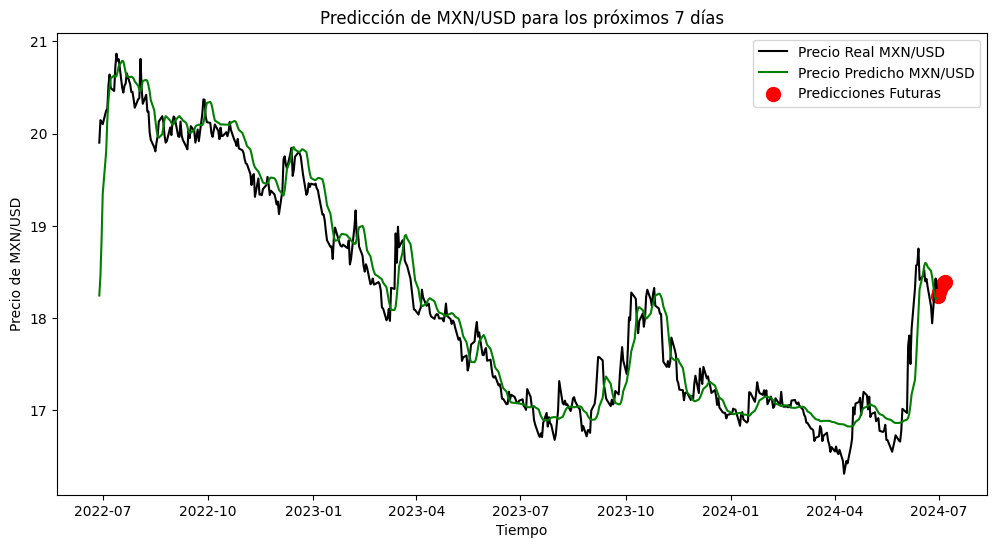

In [34]:
def predict_future(days_ahead):
    """
    Predice los precios futuros de MXN/USD para un número específico de días.

    Parameters:
    days_ahead (int): Número de días en el futuro para los cuales se desea hacer la predicción.

    Returns:
    None
    """
    # Obtener los datos más recientes
    latest_data = mxn_usd.history(period="3mo")  # Obtenemos los últimos 90 días de datos

    if latest_data.empty or len(latest_data) < prediction_days:
        print(f"No hay suficientes datos. Se necesitan al menos {prediction_days} días.")
        return

    # Preparar los datos más recientes
    latest_prices = latest_data['Close'].values[-prediction_days:].reshape(-1, 1)
    latest_prices_scaled = scaler.transform(latest_prices)

    # Hacer predicciones para los días especificados
    future_predictions = []
    current_prediction = latest_prices_scaled[-prediction_days:]

    for _ in range(days_ahead):
        X_latest = current_prediction.reshape(1, prediction_days, 1)
        next_day_prediction = model.predict(X_latest)
        future_predictions.append(next_day_prediction[0, 0])
        current_prediction = np.roll(current_prediction, -1)
        current_prediction[-1] = next_day_prediction

    # Convertir predicciones a precios reales
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Generar fechas futuras
    last_date = latest_data.index[-1]
    future_dates = [last_date + pd.Timedelta(days=i+1) for i in range(days_ahead)]

    # Imprimir predicciones
    for date, price in zip(future_dates, future_predictions):
        print(f"Predicción para {date.strftime('%Y-%m-%d')}: {price[0]}")

    # Visualizar los resultados incluyendo las predicciones futuras
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data['Close'].values, color='black', label='Precio Real MXN/USD')
    plt.plot(test_data.index, predicted_prices, color='green', label='Precio Predicho MXN/USD')
    plt.scatter(future_dates, future_predictions, color='red', marker='o', s=100, label='Predicciones Futuras')
    plt.title(f'Predicción de MXN/USD para los próximos {days_ahead} días')
    plt.xlabel('Tiempo')
    plt.ylabel('Precio de MXN/USD')
    plt.legend()
    plt.show()

predict_future(7)  # Predicción para una semana